In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import notebook
import pandas as pd

import SGD_BB
from utils import compute_stats, get_grad
from MB_LBFGS import LBFGS

In [2]:
import matplotlib.style as style

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batch_size = 64
overlap_ratio = 0.25  # for LBFGS
max_iter = 20

In [4]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


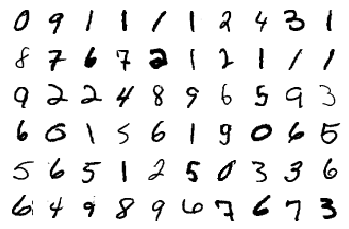

In [19]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')
figure.savefig("mnist_example.pdf", bbox_inches='tight')

In [6]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [7]:
optimizers = [
    'SGD',
    'SGD with momentum',
    'Adam',
    'BB'   
]

In [8]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images).cpu()  #log probabilities
loss = criterion(logps, labels)  #calculate the NLL loss


In [9]:
def train(model, train_loader, optimizer, epoch, opt_name, criterion):
    running_loss = 0.
    model.train()
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("{}: Epoch {} - Training loss: {}".format(opt_name,
                                                    epoch,
                                                    running_loss/len(train_loader)))
    return running_loss/len(train_loader)


def test(model, test_loader, criterion, epoch, opt_name):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            test_loss += criterion(output, labels).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('{}: Epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(opt_name,
                                                                                            epoch,
                                                                                            test_loss,
                                                                                            correct,
                                                                                            len(test_loader.dataset),
                                                                                            100. * correct / len(test_loader.dataset)))
    
    return test_loss, 100. * correct / len(test_loader.dataset)

In [11]:
train_losses = {}
val_losses = {}
val_accs = {}
times = {}

for opt_name in optimizers:
    
    input_size = 784
    hidden_sizes = [128, 64]
    output_size = 10

    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], output_size),
                          nn.LogSoftmax(dim=1))
    
    criterion = nn.CrossEntropyLoss()

    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), 
                              lr=0.003)
        
    if opt_name == 'SGD with momentum':
        optimizer = optim.SGD(model.parameters(), 
                              lr=0.003, 
                              momentum=0.9)
        
    if opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters())
        
    if opt_name == 'BB':
        optimizer = BB_DL.BB(model.parameters(), 
                             lr=0.003, 
                             steps=len(trainloader), 
                             beta=4. / len(trainloader), 
                             max_lr=1, min_lr=1e-5)
    
    
    train_losses[opt_name] = []
    val_losses[opt_name] = []
    val_accs[opt_name] = []
    
    time0 = time()
    epochs = 15
    for epoch in notebook.tqdm(range(epochs)):
        train_loss = train(model, trainloader, optimizer, epoch, opt_name, criterion)
        val_loss, val_acc = test(model, valloader, criterion, epoch, opt_name)
        
        train_losses[opt_name].append(train_loss)
        val_losses[opt_name].append(val_loss)
        val_accs[opt_name].append(val_acc)
        
    times[opt_name] = (time()-time0)/60

SGD: Epoch 0 - Training loss: 1.8927973308034542
SGD: Epoch 0 - Test set: Average loss: 1.2492, Accuracy: 7173/10000 (72%)
SGD: Epoch 1 - Training loss: 0.8566670940438313
SGD: Epoch 1 - Test set: Average loss: 0.5983, Accuracy: 8493/10000 (85%)
SGD: Epoch 2 - Training loss: 0.5227603779545725
SGD: Epoch 2 - Test set: Average loss: 0.4420, Accuracy: 8786/10000 (88%)
SGD: Epoch 3 - Training loss: 0.4268578240421535
SGD: Epoch 3 - Test set: Average loss: 0.3878, Accuracy: 8901/10000 (89%)
SGD: Epoch 4 - Training loss: 0.3841863465048611
SGD: Epoch 4 - Test set: Average loss: 0.3567, Accuracy: 8972/10000 (90%)
SGD: Epoch 5 - Training loss: 0.3585413471817462
SGD: Epoch 5 - Test set: Average loss: 0.3343, Accuracy: 9030/10000 (90%)
SGD: Epoch 6 - Training loss: 0.34133920659706285
SGD: Epoch 6 - Test set: Average loss: 0.3217, Accuracy: 9073/10000 (91%)
SGD: Epoch 7 - Training loss: 0.32758779483817535
SGD: Epoch 7 - Test set: Average loss: 0.3089, Accuracy: 9115/10000 (91%)
SGD: Epoch 8 -

SGD with momentum: Epoch 0 - Training loss: 0.6487947690413832
SGD with momentum: Epoch 0 - Test set: Average loss: 0.3087, Accuracy: 9075/10000 (91%)
SGD with momentum: Epoch 1 - Training loss: 0.2822291397733856
SGD with momentum: Epoch 1 - Test set: Average loss: 0.2534, Accuracy: 9243/10000 (92%)
SGD with momentum: Epoch 2 - Training loss: 0.22649279335287334
SGD with momentum: Epoch 2 - Test set: Average loss: 0.2082, Accuracy: 9371/10000 (94%)
SGD with momentum: Epoch 3 - Training loss: 0.1812012719192993
SGD with momentum: Epoch 3 - Test set: Average loss: 0.1637, Accuracy: 9535/10000 (95%)
SGD with momentum: Epoch 4 - Training loss: 0.15256900687032798
SGD with momentum: Epoch 4 - Test set: Average loss: 0.1363, Accuracy: 9581/10000 (96%)
SGD with momentum: Epoch 5 - Training loss: 0.12875736713099645
SGD with momentum: Epoch 5 - Test set: Average loss: 0.1259, Accuracy: 9601/10000 (96%)
SGD with momentum: Epoch 6 - Training loss: 0.11421322516266948
SGD with momentum: Epoch 6 

Adam: Epoch 0 - Training loss: 0.3994626461514341
Adam: Epoch 0 - Test set: Average loss: 0.2339, Accuracy: 9274/10000 (93%)
Adam: Epoch 1 - Training loss: 0.19355623256851998
Adam: Epoch 1 - Test set: Average loss: 0.1658, Accuracy: 9505/10000 (95%)
Adam: Epoch 2 - Training loss: 0.1444369794786977
Adam: Epoch 2 - Test set: Average loss: 0.1398, Accuracy: 9578/10000 (96%)
Adam: Epoch 3 - Training loss: 0.11763365612899475
Adam: Epoch 3 - Test set: Average loss: 0.1060, Accuracy: 9662/10000 (97%)
Adam: Epoch 4 - Training loss: 0.09868771094642183
Adam: Epoch 4 - Test set: Average loss: 0.1028, Accuracy: 9689/10000 (97%)
Adam: Epoch 5 - Training loss: 0.08577598011129096
Adam: Epoch 5 - Test set: Average loss: 0.1021, Accuracy: 9672/10000 (97%)
Adam: Epoch 6 - Training loss: 0.07712933354562264
Adam: Epoch 6 - Test set: Average loss: 0.0921, Accuracy: 9707/10000 (97%)
Adam: Epoch 7 - Training loss: 0.06860432259007189
Adam: Epoch 7 - Test set: Average loss: 0.0948, Accuracy: 9721/10000 

BB: Epoch 0 - Training loss: 1.8346500193386444
BB: Epoch 0 - Test set: Average loss: 1.1688, Accuracy: 7341/10000 (73%)
BB: Epoch 1 - Training loss: 0.8167138719228285
BB: Epoch 1 - Test set: Average loss: 0.5846, Accuracy: 8479/10000 (85%)
BB: Epoch 2 - Training loss: 0.48212331241127776
BB: Epoch 2 - Test set: Average loss: 0.3990, Accuracy: 8873/10000 (89%)
BB: Epoch 3 - Training loss: 0.37766075785607417
BB: Epoch 3 - Test set: Average loss: 0.3513, Accuracy: 8960/10000 (90%)
BB: Epoch 4 - Training loss: 0.33077867742953526
BB: Epoch 4 - Test set: Average loss: 0.2927, Accuracy: 9157/10000 (92%)
BB: Epoch 5 - Training loss: 0.29069801715454824
BB: Epoch 5 - Test set: Average loss: 0.2174, Accuracy: 9350/10000 (94%)
BB: Epoch 6 - Training loss: 0.4635531419971541
BB: Epoch 6 - Test set: Average loss: 0.1999, Accuracy: 9371/10000 (94%)
BB: Epoch 7 - Training loss: 0.180019338470278
BB: Epoch 7 - Test set: Average loss: 0.3277, Accuracy: 8996/10000 (90%)
BB: Epoch 8 - Training loss: 

In [4]:
def plot_train_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on MNIST Train set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
        plt.grid()
    plt.show()
    f.savefig("/results/mnist_train_losses.pdf", bbox_inches='tight')


def plot_val_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o' , label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on MNIST Validation set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
        plt.grid()
    plt.show()
    f.savefig("/results/mnist_val_losses.pdf", bbox_inches='tight')
    

def plot_val_accuracy(accs):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in accs.keys():
            plt.plot(np.arange(len(accs[opt])) + 1, accs[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(accs['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Accuracy on MNIST Validation set', fontsize=25)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Accuracy, %', size=24)
        plt.grid()
    plt.show()
    f.savefig("/results/mnist_val_accuracy.pdf", bbox_inches='tight')


In [20]:
train_losses['SGD-momentum'] = train_losses['SGD with momentum']
train_losses.pop('SGD with momentum')
val_losses['SGD-momentum'] = val_losses['SGD with momentum']
val_losses.pop('SGD with momentum')
val_accs['SGD-momentum'] = val_accs['SGD with momentum']
val_accs.pop('SGD with momentum')
times['SGD-momentum'] = times['SGD with momentum']
times.pop('SGD with momentum')

3.1023415168126425

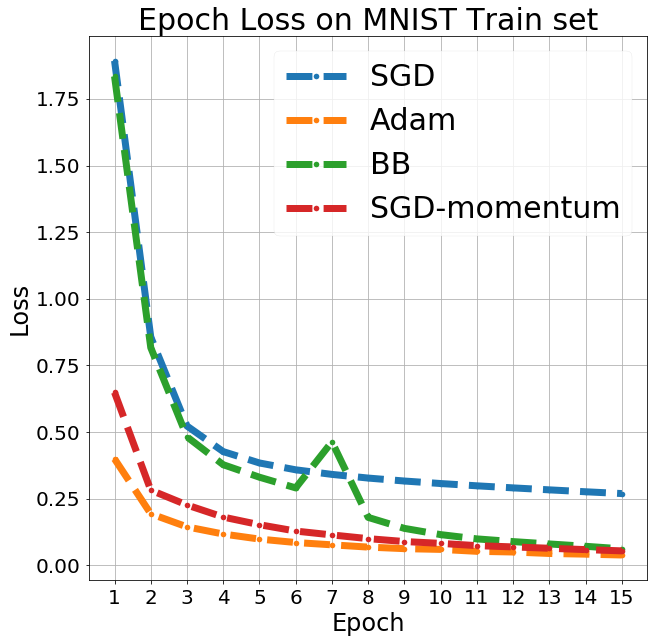

In [21]:
plot_train_losses(train_losses)

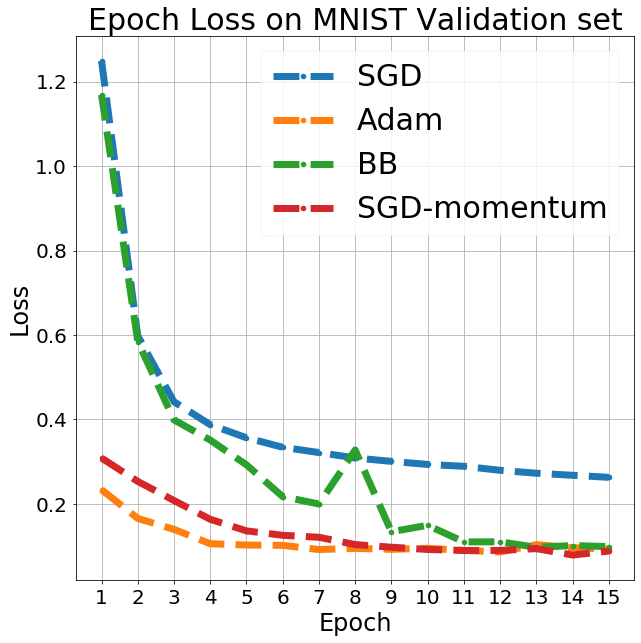

In [22]:
plot_val_losses(val_losses)

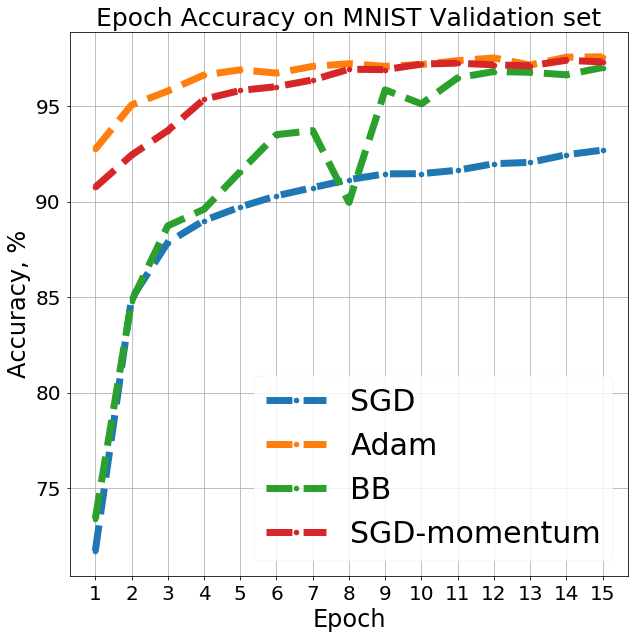

In [23]:
plot_val_accuracy(val_accs)

In [24]:
t = pd.DataFrame()
t['Optimizer'] = times.keys()
t['Time'] = times.values()
t['Acc 5'] = np.array(list(val_accs.values()))[:,4]
t['Acc 10'] = np.array(list(val_accs.values()))[:,9]
t['Acc 15'] = np.array(list(val_accs.values()))[:,14]

In [25]:
t

,Optimizer,Time,Acc 5,Acc 10,Acc 15
0,SGD,2.810485,89.72,91.46,92.69
1,Adam,3.800088,96.89,97.17,97.57
2,BB,3.326490,91.57,95.11,97.01
3,SGD-momentum,3.102342,95.81,97.19,97.30


In [18]:
print(t.to_latex(index=False, 
                float_format="%.2f",
                multicolumn_format=True,
                multirow = True,
                multicolumn = True
                ))

\begin{tabular}{lrrrr}
\toprule
         Optimizer &  Time &  Acc 5 &  Acc 10 &  Acc 15 \\
\midrule
               SGD &  2.81 &  89.72 &   91.46 &   92.69 \\
 SGD with momentum &  3.10 &  95.81 &   97.19 &   97.30 \\
              Adam &  3.80 &  96.89 &   97.17 &   97.57 \\
                BB &  3.33 &  91.57 &   95.11 &   97.01 \\
\bottomrule
\end{tabular}

